In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
merged_data = pd.merge(customers, transactions, on='CustomerID', how='inner')
print(merged_data.head())

  CustomerID      CustomerName         Region  SignupDate TransactionID  \
0      C0001  Lawrence Carroll  South America  2022-07-10        T00015   
1      C0001  Lawrence Carroll  South America  2022-07-10        T00932   
2      C0001  Lawrence Carroll  South America  2022-07-10        T00085   
3      C0001  Lawrence Carroll  South America  2022-07-10        T00445   
4      C0001  Lawrence Carroll  South America  2022-07-10        T00436   

  ProductID      TransactionDate  Quantity  TotalValue   Price  
0      P054  2024-01-19 03:12:55         2      114.60   57.30  
1      P022  2024-09-17 09:01:18         3      412.62  137.54  
2      P096  2024-04-08 00:01:00         2      614.94  307.47  
3      P083  2024-05-07 03:11:44         2      911.44  455.72  
4      P029  2024-11-02 17:04:16         3     1300.92  433.64  


In [3]:
merged_data['Region'] = merged_data['Region'].fillna('Unknown')


for date_col in ['SignupDate', 'TransactionDate']:
    merged_data[date_col] = pd.to_datetime(merged_data[date_col], errors='coerce')
merged_data = merged_data.dropna(subset=['SignupDate', 'TransactionDate'])

merged_data['Region'] = merged_data['Region'].astype(str)

print("Post-cleaning column types:")
print(merged_data.dtypes)
print("Post-cleaning missing values:")
print(merged_data.isnull().sum())

Post-cleaning column types:
CustomerID                 object
CustomerName               object
Region                     object
SignupDate         datetime64[ns]
TransactionID              object
ProductID                  object
TransactionDate    datetime64[ns]
Quantity                    int64
TotalValue                float64
Price                     float64
dtype: object
Post-cleaning missing values:
CustomerID         0
CustomerName       0
Region             0
SignupDate         0
TransactionID      0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [4]:
latest_date = merged_data['TransactionDate'].max()
merged_data['Recency'] = (latest_date - merged_data['TransactionDate']).dt.days

frequency = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

monetary = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

In [5]:
# Merge RFM features
rfm = pd.merge(frequency, monetary, on='CustomerID')
rfm = pd.merge(rfm, merged_data[['CustomerID', 'Recency']].drop_duplicates(), on='CustomerID')
merged_data = merged_data.dropna(subset=['CustomerID', 'ProductID', 'SignupDate', 'CustomerName', 'TransactionID'])

In [6]:
merged_data.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price,Recency
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30,344
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54,102
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47,264
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72,235
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64,55


In [7]:
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

pca = PCA(n_components=2)
reduced_rfm = pca.fit_transform(scaled_rfm)
print(f"Explained Variance Ratio by PCA: {pca.explained_variance_ratio_}")

Explained Variance Ratio by PCA: [0.57882987 0.33264372]


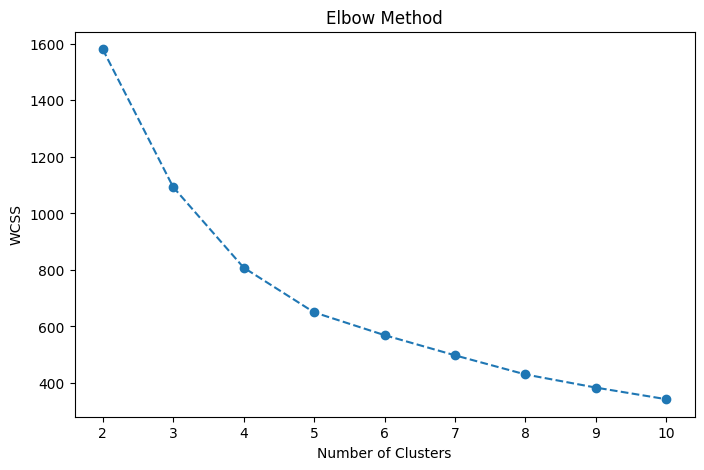

In [8]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_rfm)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [9]:
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(reduced_rfm)

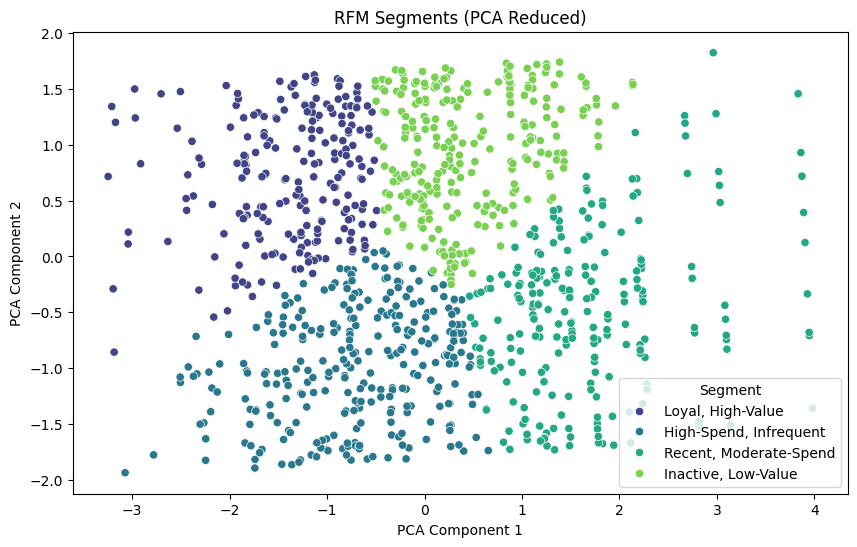

In [10]:
cluster_mapping = {
    0: 'Loyal, High-Value',
    1: 'Inactive, Low-Value',
    2: 'Recent, Moderate-Spend',
    3: 'High-Spend, Infrequent'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_mapping)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_rfm[:, 0], y=reduced_rfm[:, 1], hue=rfm['Segment'], palette='viridis')
plt.title('RFM Segments (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Segment')
plt.show()

In [11]:
dbi = davies_bouldin_score(reduced_rfm, rfm['Cluster'])
silhouette = silhouette_score(reduced_rfm, rfm['Cluster'])
print(f"Davies-Bouldin Index: {dbi}")
print(f"Silhouette Score: {silhouette}")

Davies-Bouldin Index: 0.8743273999634078
Silhouette Score: 0.3712667685386236
